In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from shutil import copyfile

In [3]:
copyfile(src = "../input/house-prices-advanced-regression-techniques/train.csv", dst = "../working/train.csv")
copyfile(src = "../input/house-prices-advanced-regression-techniques/test.csv", dst = "../working/test.csv")
copyfile(src = "../input/house-prices-advanced-regression-techniques/sample_submission.csv", dst = "../working/submission.csv")

'../working/submission.csv'

In [4]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
submit = pd.read_csv('submission.csv')
print('train data set : {}'.format(df_train.shape))
print('test data set : {}'.format(df_test.shape))

train data set : (1460, 81)
test data set : (1459, 80)


In [5]:
def sort_rank(col_name):
    df_temp = pd.pivot_table(df_train,                # 피벗할 데이터프레임
                         index = col_name,    # 행 위치에 들어갈 열
                         #columns = 'SalePrice',    # 열 위치에 들어갈 열
                         values = 'SalePrice',     # 데이터로 사용할 열
                         aggfunc = 'mean')   # 데이터 집계함수
    df_temp = df_temp.reset_index()
    df_temp = df_temp.sort_values('SalePrice')
    df_temp[col_name + '_str'] = df_temp[col_name].astype(str)
    df_temp = df_temp.reset_index(drop=True)

    sns.scatterplot(data=df_temp, x=col_name + '_str', y='SalePrice')
    return df_temp[col_name]

def Make_dic_table_numeric(x):
    dic = {}
    for i in range(0, len(x)):
        dic[int(x[i])] = i+1
    return dic

def Make_dic_table_category(x):
    dic = {}
    for i in range(0, len(x)):
        dic[x[i]] = i+1
    return dic

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# EDA 수행

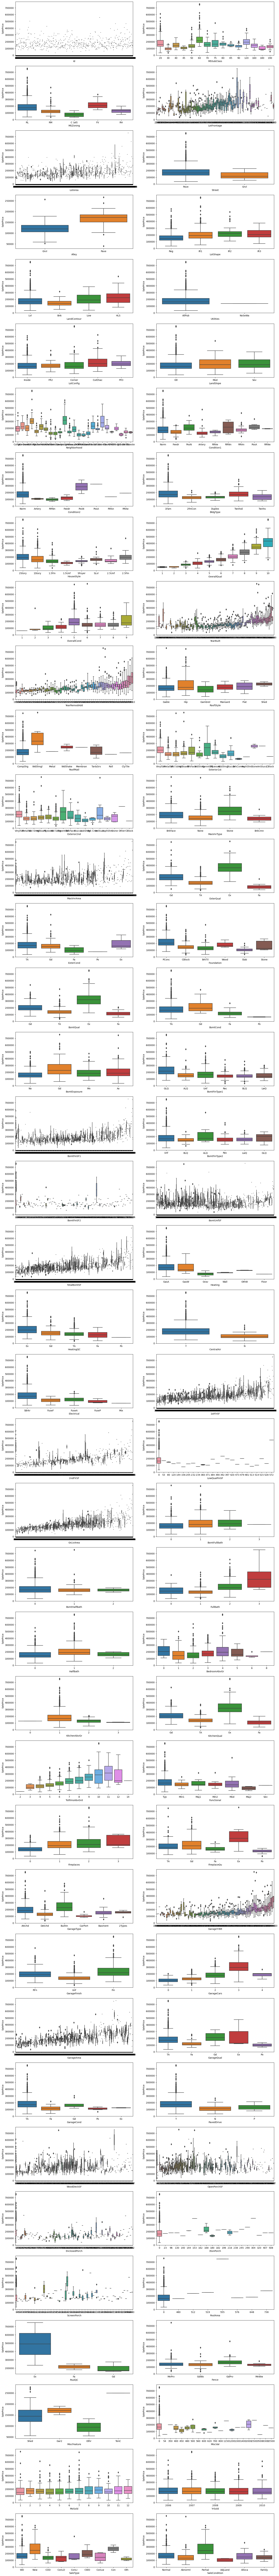

In [7]:
col_n = 2
row_n = 40
fig, ax = plt.subplots(ncols=col_n, nrows=row_n, figsize=(20,row_n*5))

for i,col in enumerate(df_train.columns[:-1]):
    sns.boxplot(data=df_train, x= df_train[col], y='SalePrice', ax=ax[int(i/col_n),int(i%col_n)])

# 성능 개선 방법
### 1) target과 관련 없는 features 삭제 + 결측치가 너무 많은 features 삭제
### 2) features에 대한 스케일링/로그 적용 + target에 로그 적용
### 3) 다항회귀 적용
### 4) 규제 적용
### 5) 숫자형 카테고리 변수 선형화

# 데이터 전처리 (학습 데이터와 테스트 데이터 동시 처리)

In [10]:
# 학습 데이터는 0 ~ 1459
# 테스트 데이터는 1460 ~ 2918
df = pd.concat([df_train, df_test], axis=0)
df = df.reset_index(drop=True)
df.drop(['Id'], axis=1, inplace=True)

In [11]:
# 결측치를 평균으로 채우기
df.fillna(df.mean(), inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


In [12]:
features = df.drop(['SalePrice'], axis=1)
target = df['SalePrice'].iloc[0:1460,]
target_log = np.log1p(target)

## 1) target과 관련 없는 features 삭제 + 결측치가 너무 많은 features 삭제

In [13]:
# del_cols = ['LotConfig','LandSlope','BldgType','RoofStyle','BsmtExposure','BsmtFinType1','BsmtFinType2','Utilities',
# 'BsmtFullBath','BsmtHalfBath','HalfBath','KitchenAbvGr','Functional','GarageCond','MoSold','YrSold']


# #target과 관련 없는 features 삭제
# features.drop(del_cols, axis=1, inplace=True)

# 결측치가 너무 많은 FireplaceQu, PoolQC, MiscFeature, Alley 삭제
features.drop(['FireplaceQu', 'PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis=1, inplace=True)

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [15]:
features_ohe = pd.get_dummies(features)
features_ohe_train = features_ohe.iloc[0:1460, :]

X_train, X_test, y_train, y_test = train_test_split(features_ohe_train, target_log, random_state=16)

model_imp1 = LinearRegression()
model_imp1.fit(X_train, y_train)
y_pred = model_imp1.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

0.21056989208099047

## 2) features에 대한 로그 / 스케일링 적용

In [16]:
from sklearn.preprocessing import MinMaxScaler

In [18]:
col_category = ['MSZoning','Street','LotShape','LandContour','Neighborhood','Condition1','Condition2','HouseStyle','RoofMatl',
'Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond','Heating',
'HeatingQC','CentralAir','Electrical','KitchenQual','GarageType','GarageFinish','GarageQual','PavedDrive',
'SaleType','SaleCondition', 'LotConfig', 'LandSlope', 'BldgType', 'RoofStyle', 'BsmtExposure','BsmtFinType1', 'BsmtFinType2', 'Utilities', 'Functional', 'GarageCond']

features_numeric = features.drop(col_category, axis=1)

In [19]:
features_numeric_log = np.log1p(features_numeric)

In [21]:
scaler = MinMaxScaler()
features_numeric_scaled = scaler.fit_transform(features_numeric_log)
features_scaled = pd.DataFrame(features_numeric_scaled, columns=features_numeric_log.columns)

In [22]:
features_scaled = pd.concat([features_scaled, features[col_category]], axis=1)
features_scaled_ohe = pd.get_dummies(features_scaled)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(features_scaled_ohe.iloc[0:1460], target_log, random_state=16)

model_imp2 = LinearRegression()
model_imp2.fit(X_train, y_train)
y_pred = model_imp2.predict(X_test)
mean_squared_error(y_test, y_pred)
np.sqrt(mean_squared_error(y_test, y_pred))

960638315.9679358

## 3) 다항회귀 적용

In [25]:
from sklearn.preprocessing import PolynomialFeatures

In [26]:
model_poly = PolynomialFeatures(degree=2)
features_poly = model_poly.fit_transform(features_ohe_train)
X_train, X_test, y_train, y_test = train_test_split(features_poly, target_log, random_state=16)
model_imp3 = LinearRegression()
model_imp3.fit(X_train, y_train)
y_pred = model_imp3.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

2.212671120875424

In [27]:
from sklearn.model_selection import cross_val_score

In [29]:
rmse = cross_val_score(model_imp1, features_ohe_train , target_log, scoring='neg_mean_squared_error', cv=5)
np.sqrt(-1 * rmse)

array([0.13531891, 0.16458082, 0.16765673, 0.11089753, 0.19804828])

# submit #1

In [30]:
y_pred = model_imp1.predict(features_ohe.iloc[1460:2919, :])
pred = np.expm1(y_pred)

In [31]:
submit['SalePrice'] = pred
submit.to_csv('house_price_submission.csv', index=False)

##  4) 규제 적용

In [32]:
from sklearn.linear_model import Ridge

In [33]:
a_list = [0, 0.5, 1, 10, 20, 50, 100]
for a in a_list:
    model_ridge = Ridge(alpha = a)
    rmse = cross_val_score(model_ridge, features_ohe_train , target_log, scoring='neg_mean_squared_error', cv=5)
    print('{} : {}'.format(a, np.sqrt(-1 * rmse)))

0 : [5.02127310e+08 4.32500907e+08 7.09756926e+07 8.82443250e+08
 9.76305689e+08]
0.5 : [0.11937795 0.15727025 0.14809155 0.11509492 0.19128866]
1 : [0.11726332 0.1543912  0.14209128 0.11653053 0.18895533]
10 : [0.11493074 0.14824158 0.13014038 0.11753865 0.18587342]
20 : [0.11498057 0.1484643  0.1294329  0.1174771  0.18742335]
50 : [0.11599417 0.15037999 0.13010066 0.11793862 0.19156232]
100 : [0.11781532 0.15293636 0.13140098 0.11927236 0.19634274]


## Submit #2

In [34]:
X_train, X_test, y_train, y_test = train_test_split(features_ohe_train , target_log, random_state=16)
model_ridge = Ridge(alpha = 20)
model_ridge.fit(X_train, y_train)
y_pred = model_ridge.predict(features_ohe.iloc[1460:2919, :])
pred = np.expm1(y_pred)
submit['SalePrice'] = pred
submit.to_csv('house_price_submission_ridge.csv', index=False)

## 5) 숫자형 카테고리 변수 선형화

In [35]:
#features_ohe를 사용하면 된다
cols_numeric_category = ['MSSubClass','OverallQual','OverallCond','YearBuilt','FullBath','BedroomAbvGr', 'YearRemodAdd',
                 'TotRmsAbvGrd','Fireplaces','GarageCars']

### 예시

{30: 1,
 180: 2,
 45: 3,
 190: 4,
 90: 5,
 160: 6,
 50: 7,
 85: 8,
 40: 9,
 70: 10,
 80: 11,
 20: 12,
 75: 13,
 120: 14,
 60: 15}

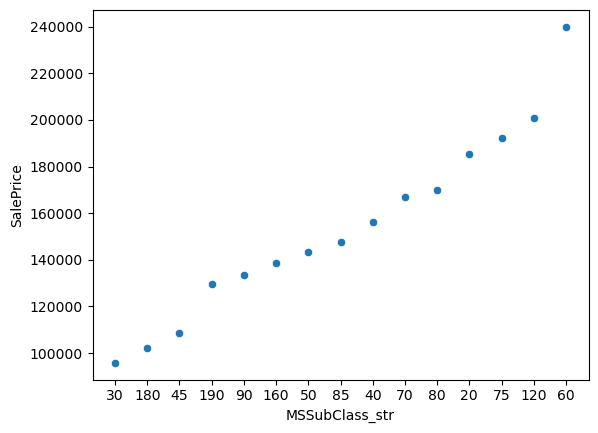

In [48]:
Make_dic_table_numeric(sort_rank('MSSubClass'))

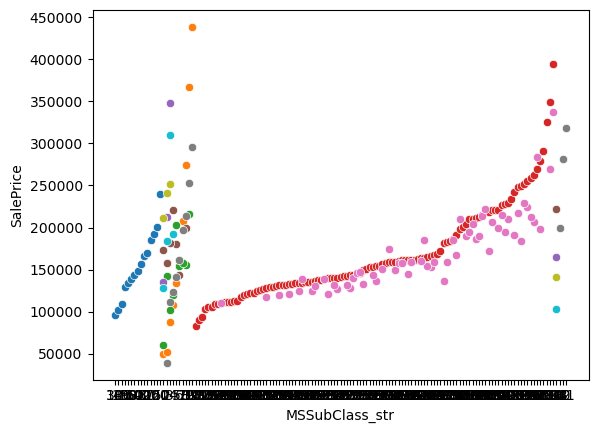

In [36]:
for col in cols_numeric_category:
    dic = Make_dic_table_numeric(sort_rank(col))
    features_ohe[col] = features_ohe[col].apply(lambda x:dic[x] if x in dic else np.nan)

In [41]:
features_ohe.fillna(features_ohe.mean(), inplace=True)

In [42]:
features_ohe[cols_numeric_category].isnull().sum().sum()

0

In [43]:
model_ridge = Ridge(alpha = 20)
rmse = cross_val_score(model_ridge, features_ohe.iloc[0:1460] , target_log, scoring='neg_mean_squared_error', cv=5)
np.sqrt(-1 * rmse)

array([0.11211403, 0.14930201, 0.13348523, 0.12341758, 0.185693  ])

In [44]:
a_list = [0, 0.5, 1, 10, 20, 50, 100]
for a in a_list:
    model_ridge = Ridge(alpha = a)
    rmse = cross_val_score(model_ridge, features_ohe.iloc[0:1460] , target_log, scoring='neg_mean_squared_error', cv=5)
    print('{} : {}'.format(a, np.sqrt(-1 * rmse)))

0 : [3.31472636e+08 5.13659092e+08 1.87304018e+08 6.63248837e+08
 8.45688246e+08]
0.5 : [0.11690065 0.15748502 0.15056292 0.1199239  0.18913843]
1 : [0.11455027 0.15529153 0.14408148 0.12121789 0.18706743]
10 : [0.11162851 0.14941629 0.1333883  0.12294853 0.18429031]
20 : [0.11211403 0.14930201 0.13348523 0.12341758 0.185693  ]
50 : [0.11431718 0.15066399 0.13533627 0.12454452 0.18942636]
100 : [0.11733683 0.15266024 0.13755503 0.12600914 0.19382095]


## Submit #3

In [45]:
X_train, X_test, y_train, y_test = train_test_split(features_ohe.iloc[0:1460] , target_log, random_state=16)
model_ridge = Ridge(alpha = 10)
model_ridge.fit(X_train, y_train)
y_pred = model_ridge.predict(features_ohe.iloc[1460:2919, :])
pred = np.expm1(y_pred)
submit['SalePrice'] = pred
submit.to_csv('house_price_submission_ridge_linear.csv', index=False)